***This notebook needs to be executed in pyvizenv env to display all the images in panel 
and needs python-dotenv  to load env variables***

This can be done by activating the pyvizenv env and also loading the alpaca apis using below commands

- conda activate pyvizenv
- pip install python-dotenv

***This notebook gets the NFT collections data using OpenSea API and current ETH price using Alpaca API**
Therefore to run the notebook the API keys for OpenSea API and Alpacha API needs to be defined in the .env file as below
- opensea_api_key="XXXXXXXXXX"
- ALPACA_API_KEY="XXXXXXXXXX"
- ALPACA_SECRET_KEY="XXXXXXXXXX"


In [7]:
pip install hvplot

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
from datetime import datetime 
from alpaca_trade_api.rest import REST, TimeFrame
import time
from time import sleep
import datetime
import csv
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML 
import panel as pn
pn.extension('plotly')
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import date
import hvplot.pandas

In [2]:
# Load .env enviroment variables
load_dotenv()
# opensea_api_key = os.getenv("opensea_api_key")
# define headers as global variable it is used in multiple get API calls
headers = {
        "Accept": "application/json",
        "X-API-KEY": "af52674dbe4741d481d93be2d67ba086"
    }


In [3]:
#The event data for different NFT collections are retreived for 6 months based on below start/end dates
start_date = datetime.datetime(2022, 3, 1)
end_date = datetime.datetime(2022, 8, 22)

In [4]:

asset_base_url = "https://api.opensea.io/api/v1/assets"
collection_slug="boredapeyachtclub"

#this function will invoke opensea API to get different assets in the NFT collection
# it takes the collection name and the limit of assets to be fetched
def get_asset(collection_slug,limit):
    
    query = { 
        "include_orders":False,
        "collection_slug":collection_slug,
        "limit":limit
    }
    response = requests.request("GET", asset_base_url, headers=headers,params=query)
    return response.json()

asset_limit=200
doodle_assets_data=get_asset(collection_slug,asset_limit)
#print(json.dumps(doodle_assets,indent=4))
doodle_assets = doodle_assets_data["assets"]
#print(json.dumps(doodle_assets,indent=4))

#this function will iterater over the asset json data and get the thumbnail image URL
# it will return a list of thumbnail URLs
def get_asset_image_urls(assets):
    asset_image_urls=[]
    for asset in assets:
        asset_image_thumbnail_url = asset["image_thumbnail_url"]
        if asset_image_thumbnail_url is not None:
            asset_image_urls.append(asset_image_thumbnail_url)
    return asset_image_urls

asset_image_urls = get_asset_image_urls(doodle_assets)

total_images_to_display=10

#this method will pick random thumbnail URLs from the list and fetch images using the URL
# it will create a panel row with the images and add the row to the panel column
# and will return the column
def create_panel(asset_image_urls,total_images_to_display):
    image_rows = pn.Row()
    for i in range(0,total_images_to_display):
        random_url = np.random.choice(asset_image_urls)
        im = Image.open(requests.get(random_url, stream=True).raw)
        fig = get_image_figure(im)
        image_rows.append(fig)
    panel_column = pn.Column(image_rows)
    return panel_column

#this function takes the image object and wraps it in a figure and returns
# the figure 
def get_image_figure(image):
    fig=plt.figure(figsize=(0.75,0.75))
    plt.imshow(image)
    plt.close(fig)
    return fig

create_panel(asset_image_urls,total_images_to_display)

asset_limit=200
total_images_to_display=10

# this is a function that consolidates all above functions 
# i.e 1) fetch asset data 2) get image URL from response JSON 3) create image and add it to panel
def display_colleaction_assets(collection_slug,asset_limit,total_images_to_display):
    collection_slug_assets_data=get_asset(collection_slug,asset_limit)
    collection_slug_assets = collection_slug_assets_data["assets"]
    asset_image_urls = get_asset_image_urls(collection_slug_assets)
    panel = create_panel(asset_image_urls,total_images_to_display)
    return panel



Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
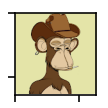
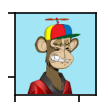
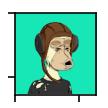
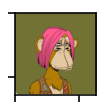
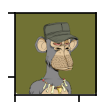
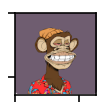
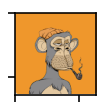
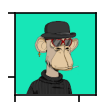
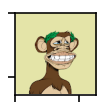
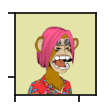

In [5]:
#1
#invoke the function with the collection name and display 
# random thumbnails of the NFTs in the collection
panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel



In [6]:
#this function invokes the opensea API to get the successful events for a NFT collection
# for a particular date range
def get_events(url,start_date, end_date,event_type, collection_slug,limit=1, cursor=''):
    
    query = { 
        "only_opensea": "true", 
        "occurred_before": end_date,
        "occurred_after": start_date,
        "event_type":event_type,
        "collection_slug":collection_slug,
        "limit":limit,
        "cursor": cursor
    }
    
    response_data = requests.request("GET", url, headers=headers, params=query)
    json_data = response_data.json()
    #print(json_data)
    return json_data

In [7]:
collection_stats_base_url = "https://api.opensea.io/api/v1/collection/"
def get_colection_stats(collection_slug):
    url = collection_stats_base_url+collection_slug+"/stats"
    
    response_data = requests.request("GET", url, headers=headers)
    json_data = response_data.json()
    return json_data

#get the stats for the collection for analysis
all_collection_stats={}
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats



***The below function parse_event was available on github repo**
Ref - https://github.com/Checco9811/opensea-api-nft-sales/blob/main/script.py

In [8]:
#this function parses the event JSON data and gets the data of interest 
# and creates a new dictinary object and returns that
def parse_event(event):
    record = {}
    asset = event.get('asset')
    if asset == None:
        return None # if there's no asset that means it's not a single NFT transaction so skip this item

    #collection
    record['collection_slug'] = asset['collection']['slug']
    record['collection_name'] = asset['collection']['name']
    record['collection_url'] = "https://opensea.io/collection/" + asset['collection']['slug']

    #asset
    record['asset_id'] = asset['id']
    record['asset_name'] = asset['name']
    record['asset_description'] = asset['description']
    record['asset_contract_date'] = asset['asset_contract']['created_date']
    record['asset_url'] = asset['permalink']
    record['asset_img_url'] = asset['image_url']

    #event
    record['event_id'] = event['id']
    record['event_time'] = event.get('created_date')
    record['event_auction_type'] = event.get('auction_type')
    record['event_contract_address'] = event.get('contract_address')
    record['event_quantity'] = event.get('quantity')
    record['event_payment_symbol'] =  None if event.get('payment_token') == None else event.get('payment_token').get('symbol')

    decimals = 18
    if event.get('payment_token') != None:
        decimals = event.get('payment_token').get('decimals')

    price_str = event['total_price']

    try: 
        if len(price_str) < decimals:
            price_str =  "0." + (decimals-len(price_str)) * "0" + price_str
            record['event_total_price'] = float(price_str)
        else:
            record['event_total_price'] = float(price_str[:-decimals] + "." + price_str[len(price_str)-decimals:])
    except:
        print(event)

    return record

In [9]:
pause = 1
#this function consolidates the invocation to calling API to get the events and 
# parsing the event json data and returns a list

def fetch_all_events(url,start_date, end_date,event_type,collection_slug,limit, pause=1):
    result = list()
    next = ''
    fetch = True

    print(f"Fetching events between {start_date} and {end_date}")
    i =1
    while fetch:
        response = get_events(url,start_date,end_date,event_type,collection_slug, limit, cursor=next)

        for event in response['asset_events']:
            cleaned_event = parse_event(event)
            
            if cleaned_event != None:
                result.append(cleaned_event)
        
        if response['next'] is None:
            fetch = False
        else:
            next = response['next']
        print(f"fetching events for collection:{collection_slug},sleeping for:{pause}, iteration: {i}, limit:{limit}")
        i=i+1
        sleep(pause)

    return result

In [10]:
event_url = "https://api.opensea.io/api/v1/events";
event_type = "successful"
collection_slug = "boredapeyachtclub"

limit = 300

def determine_file_name(collection_slug,start_date,end_date):
    str_start_date = start_date.strftime("%m%d%Y") 
    str_end_date = end_date.strftime("%m%d%Y") 
    file_name = "Data/"+collection_slug+"_"+str_start_date+"_"+str_end_date+".csv"
    return file_name

file_name = determine_file_name(collection_slug,start_date,end_date)
#print(file_name)



In [11]:

#this function writes the event data to a csv file to avoid calling the API multiple times
# for the same date range
def write_csv(data, file_name):
    with open(file_name, mode='w', encoding='utf-8', newline='\n') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames = data[0].keys())

        writer.writeheader()
        for event in data:
            writer.writerow(event)
            

In [12]:
# this NFT collection has different assets which will have different prices based on various attributes 
# like rarity. For the sake of simplicity, we will consider the min/floor price of any of the asset
# for a particular day to determine the floor price of the collection for that day
# this function will interate though all the rows and check for different prices for a day.
# it will then pick the min of the price as the floor price for that day (irrespective of the assetId)
def consolidate_price_data_for_dates(df):
    prices_per_day={}
    for i in range(0, len(df)):
        event_date = df.iloc[i]['event_date']
        event_total_price = df.iloc[i]['event_total_price']
        #print(event_date,event_total_price )
        if event_date in prices_per_day:
            value_event_date = prices_per_day.get(event_date)
            value_event_date.append(event_total_price)
        else:
            prices_per_day[event_date]= [event_total_price]

    return prices_per_day

#prices_per_day = consolidate_price_data_for_dates(nft_event_price_df)
#prices_per_day

# once the dictonary is created with key as date and values as different prices for that date,
# iterate over the dictionary, to get the lowest value for that date and create another dictionary

def get_mean_price_data(prices_per_day):
    floor_prices={}
    for key in prices_per_day:
        prices_for_current_day = prices_per_day[key]
        floor_price_current_day = np.mean(prices_for_current_day)
        floor_prices[key]= floor_price_current_day
        #print(key, 'corresponds to', floor_prices[key],floor_price_current_day)
    return floor_prices



#floor_prices = get_floor_price_data(prices_per_day)
#floor_prices

In [13]:
#df = pd.DataFrame.from_dict(floor_prices)
#df =pd.DataFrame(floor_prices.items(), columns=['event_date', 'close'])
#df.plot()

In [14]:
event_url = "https://api.opensea.io/api/v1/events";
event_type = "successful"
collection_slug = "boredapeyachtclub"
limit =300
file_name = determine_file_name(collection_slug,start_date,end_date)

def fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                        file_name):
    #this is a dictionary to hold different dataframes
    dataframe_dict={}

    path = Path(file_name)
    if path.is_file():
        print(f'The file {file_name} exists')
    else:
        result = fetch_all_events(event_url,start_date,end_date,event_type,collection_slug, limit)
        print(f"total number of records found:{len(result)}")
        print(f"writing data to file:{file_name}")
        write_csv(result, file_name)
    
    
    nft_events_df = pd.read_csv(file_name)
    nft_event_price_df=nft_events_df[['asset_id','event_time','event_total_price']]

    nft_event_price_df['event_time']= pd.to_datetime(nft_events_df['event_time']).dt.date
    nft_event_price_df.rename(columns = {'event_time':'event_date'}, inplace = True)

    #nft_event_price_df =nft_event_price_df.set_index("event_date")
    #nft_event_price_df
    prices_per_day = consolidate_price_data_for_dates(nft_event_price_df)
    floor_prices = get_mean_price_data(prices_per_day)
    df =pd.DataFrame(floor_prices.items(), columns=['event_date', 'close'])
    
    #get the dataframe close column and calculate rolling median
    df_close = df[["close"]]
    df_close = df_close.rolling(5).median() 
    
    # re-assign the close column of the dataframe (first 4 rowa will be NAN)
    df['close'] = df_close
    #drop the rows having null data due to rolling median
    df.dropna(inplace=True)


    
    df = df.sort_values(by="event_date",axis=0, ascending=True )
    df = df.set_index('event_date')
    # Concatenate the ticker DataFrames
    df_mc = pd.concat([df], axis=1, keys=[collection_slug])
    dataframe_dict["dataframe_orig"] = df
    dataframe_dict["dataframe_for_mc_sim"] = df_mc
    return dataframe_dict

In [15]:
dataframe_dict = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_boredapeyachtclub_orig = dataframe_dict["dataframe_orig"] 
df_boredapeyachtclub = dataframe_dict["dataframe_for_mc_sim"]
    


Fetching events between 2022-03-01 00:00:00 and 2022-08-22 00:00:00
fetching events for collection:boredapeyachtclub,sleeping for:1, iteration: 1, limit:300
fetching events for collection:boredapeyachtclub,sleeping for:1, iteration: 2, limit:300
fetching events for collection:boredapeyachtclub,sleeping for:1, iteration: 3, limit:300
fetching events for collection:boredapeyachtclub,sleeping for:1, iteration: 4, limit:300
fetching events for collection:boredapeyachtclub,sleeping for:1, iteration: 5, limit:300
fetching events for collection:boredapeyachtclub,sleeping for:1, iteration: 6, limit:300
total number of records found:1731
writing data to file:Data/boredapeyachtclub_03012022_08222022.csv


C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:

def get_floor_price_data(prices_per_day):
    floor_prices={}
    for key in prices_per_day:
        prices_for_current_day = prices_per_day[key]
        floor_price_current_day = min(prices_for_current_day)
        floor_prices[key]= floor_price_current_day
        #print(key, 'corresponds to', floor_prices[key],floor_price_current_day)
    return floor_prices

#this function is to get the data using floor price, it is not used as the data fluctions a
def generate_df_using_floor_price_data(file_name):
    nft_events_df = pd.read_csv(file_name)
    nft_event_price_df=nft_events_df[['asset_id','event_time','event_total_price']]

    nft_event_price_df['event_time']= pd.to_datetime(nft_events_df['event_time']).dt.date
    nft_event_price_df.rename(columns = {'event_time':'event_date'}, inplace = True)
    prices_per_day = consolidate_price_data_for_dates(nft_event_price_df)
    floor_prices_1 = get_floor_price_data(prices_per_day)
    floor_prices_1_df =pd.DataFrame(floor_prices_1.items(), columns=['event_date', 'close'])

    df_close = floor_prices_1_df[["close"]]
    df_close = df_close.rolling(5).median() 
    df_close

    floor_prices_1_df['close'] = df_close
    floor_prices_1_df.dropna(inplace=True)
    return floor_prices_1_df
#floor_prices_1_df = generate_df_using_floor_price_data(file_name)
#floor_prices_1_df.plot()

In [17]:
def create_line_chart(data, title, xlabel, ylabel, color,rot):
    """
    Create a line chart based in the data argument.
    """
    fig=plt.figure()
    line_chart = data.plot(kind="line",
                           title=title,
                           xlabel=xlabel,
                           ylabel=ylabel,
                           color=color,
                           rot=rot)
    #line_chart.get_figure().savefig(title,bbox_inches='tight')
    plt.close(fig)
    return fig

def plot_hvplot_line(df,x,y,xlabel="date",ylable="Price in ETH"):
    line_chart = df.hvplot.line(x=x,
                                y=y,
                                xlabel=xlabel,
                                ylabel=ylable)
    return line_chart

boredapeyactchclub_line_chart= plot_hvplot_line(df_boredapeyachtclub_orig,"event_date","close")
boredapeyactchclub_line_chart



:Curve   [event_date]   (close)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


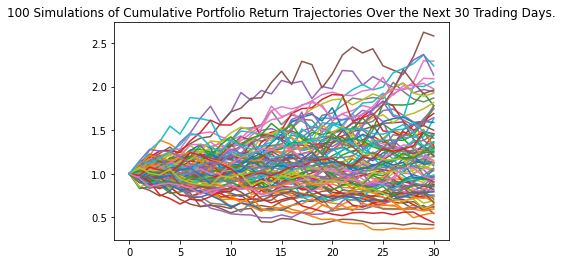

In [18]:
num_of_simulation =100
#num_of_years=1
#num_trading_days = 252*num_of_years
num_trading_days=30

def determine_simulation_image_name(collection_slug):
    return "Images/"+collection_slug+"_sim_plot.png"

def determine_distribution_image_name(collection_slug):
    return "Images/"+collection_slug+"_dist_plot.png"



def perform_monte_carlo_simulation(collection_slug,df, num_of_simulation,num_trading_days):
    MC_df= MCSimulation(
                portfolio_data = df,
                num_simulation = num_of_simulation,
                num_trading_days = num_trading_days
                )
    # Printing the simulation input data
    MC_df.portfolio_data.head()
    
    # Running a Monte Carlo simulation to forecast for the given period cumulative returns
    MC_df.calc_cumulative_return()
   
    return MC_df

MC_df_boredapeyachtclub = perform_monte_carlo_simulation(collection_slug,
                                                         df_boredapeyachtclub,
                                                         num_of_simulation,
                                                         num_trading_days)

# Plot simulation outcomes
line_plot = MC_df_boredapeyachtclub.plot_simulation()
sim_image_name=determine_simulation_image_name(collection_slug)
line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")


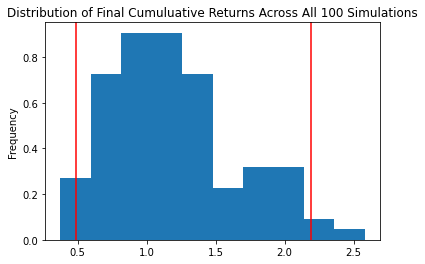

In [19]:
# Plot probability distribution and confidence intervals
dist_plot = MC_df_boredapeyachtclub.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')

In [20]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_df_boredapeyachtclub.summarize_cumulative_return()
# Print summary statistics
#print(tbl)
initial_investment = 10000
investment_returns_all_collection_slug={}

def calculate_lower_upper_bound_investment(collection_slug,initial_investment,tbl):
    # Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
    ci_lower = round(tbl[8]*initial_investment,2)
    ci_upper = round(tbl[9]*initial_investment,2)
    investment_returns_collection_slug={}
    investment_returns_collection_slug["lower_bound"]=ci_lower
    investment_returns_collection_slug["upper_bound"]=ci_upper
    # Print results
    print(f"There is a 95% chance that an initial investment of ${initial_investment} in the NFT collection {collection_slug}"
      f" over the next 30 days will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")
    investment_returns_all_collection_slug[collection_slug] = investment_returns_collection_slug

calculate_lower_upper_bound_investment(collection_slug,initial_investment,tbl)
#investment_returns_all_collection_slug

There is a 95% chance that an initial investment of $10000 in the NFT collection boredapeyachtclub over the next 30 days will end within in the range of $4897.02 and $21884.87


In [ ]:
#2

Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
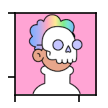
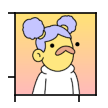
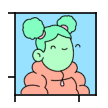
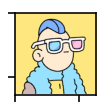
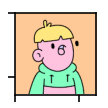
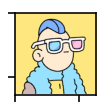
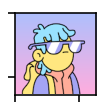
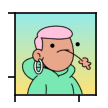
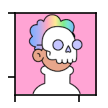
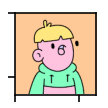

In [21]:
collection_slug="doodles-official"
panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel

In [22]:
#get the stats for the collection for analysis
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats

file_name = determine_file_name(collection_slug,start_date,end_date)
dataframe_dict = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)




df_doodles_orig = dataframe_dict["dataframe_orig"] 
df_doodles = dataframe_dict["dataframe_for_mc_sim"]
doodles_line_chart= plot_hvplot_line(df_doodles_orig,"event_date","close")
doodles_line_chart


Fetching events between 2022-03-01 00:00:00 and 2022-08-22 00:00:00
fetching events for collection:doodles-official,sleeping for:1, iteration: 1, limit:300
fetching events for collection:doodles-official,sleeping for:1, iteration: 2, limit:300
fetching events for collection:doodles-official,sleeping for:1, iteration: 3, limit:300
fetching events for collection:doodles-official,sleeping for:1, iteration: 4, limit:300
fetching events for collection:doodles-official,sleeping for:1, iteration: 5, limit:300
fetching events for collection:doodles-official,sleeping for:1, iteration: 6, limit:300
fetching events for collection:doodles-official,sleeping for:1, iteration: 7, limit:300
fetching events for collection:doodles-official,sleeping for:1, iteration: 8, limit:300
fetching events for collection:doodles-official,sleeping for:1, iteration: 9, limit:300
fetching events for collection:doodles-official,sleeping for:1, iteration: 10, limit:300
fetching events for collection:doodles-official,sle

C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


:Curve   [event_date]   (close)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


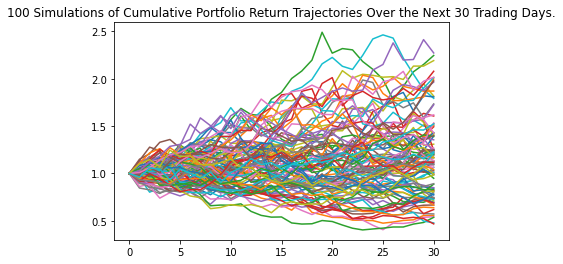

In [23]:
doodles_MC = perform_monte_carlo_simulation(collection_slug,
                                                         df_boredapeyachtclub,
                                                         num_of_simulation,
                                                         num_trading_days)

# Plot simulation outcomes
line_plot = doodles_MC.plot_simulation()
sim_image_name=determine_simulation_image_name(collection_slug)
line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")

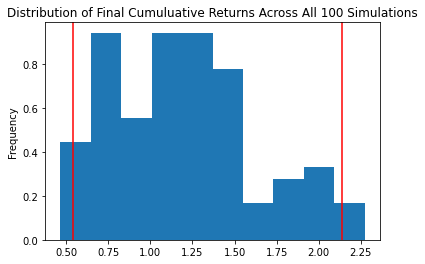

In [25]:
# Plot probability distribution and confidence intervals
dist_plot = doodles_MC.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')

In [26]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = doodles_MC.summarize_cumulative_return()
# Print summary statistics
#print(tbl)
calculate_lower_upper_bound_investment(collection_slug,initial_investment,tbl)
#investment_returns_all_collection_slug

There is a 95% chance that an initial investment of $10000 in the NFT collection doodles-official over the next 30 days will end within in the range of $5390.56 and $21384.84


In [ ]:
#3

Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
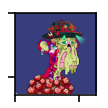
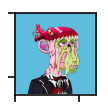
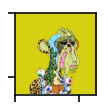
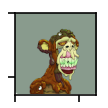
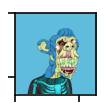
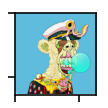
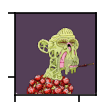
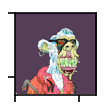
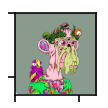
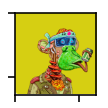

In [27]:
collection_slug = "mutant-ape-yacht-club"
panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel

In [28]:
#get the stats for the collection for analysis
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats

file_name = determine_file_name(collection_slug,start_date,end_date)

dataframe_dict = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)


df_mutant_ape_orig = dataframe_dict["dataframe_orig"] 
df_mutant_ape = dataframe_dict["dataframe_for_mc_sim"]
mutant_ape_line_chart= plot_hvplot_line(df_mutant_ape_orig,"event_date","close")
mutant_ape_line_chart


Fetching events between 2022-03-01 00:00:00 and 2022-08-22 00:00:00
fetching events for collection:mutant-ape-yacht-club,sleeping for:1, iteration: 1, limit:300
fetching events for collection:mutant-ape-yacht-club,sleeping for:1, iteration: 2, limit:300
fetching events for collection:mutant-ape-yacht-club,sleeping for:1, iteration: 3, limit:300
fetching events for collection:mutant-ape-yacht-club,sleeping for:1, iteration: 4, limit:300
fetching events for collection:mutant-ape-yacht-club,sleeping for:1, iteration: 5, limit:300
fetching events for collection:mutant-ape-yacht-club,sleeping for:1, iteration: 6, limit:300
fetching events for collection:mutant-ape-yacht-club,sleeping for:1, iteration: 7, limit:300
fetching events for collection:mutant-ape-yacht-club,sleeping for:1, iteration: 8, limit:300
fetching events for collection:mutant-ape-yacht-club,sleeping for:1, iteration: 9, limit:300
fetching events for collection:mutant-ape-yacht-club,sleeping for:1, iteration: 10, limit:300
f

C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


:Curve   [event_date]   (close)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


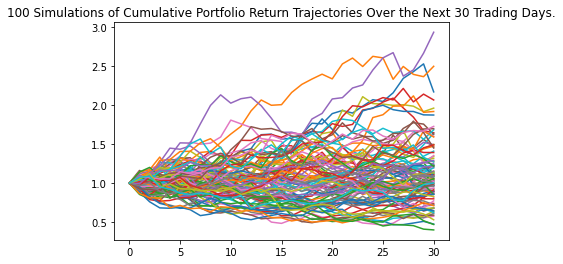

In [29]:
mutant_ape_MC = perform_monte_carlo_simulation(collection_slug,
                                                         df_boredapeyachtclub,
                                                         num_of_simulation,
                                                         num_trading_days)

# Plot simulation outcomes
line_plot = mutant_ape_MC.plot_simulation()
sim_image_name=determine_simulation_image_name(collection_slug)
line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")

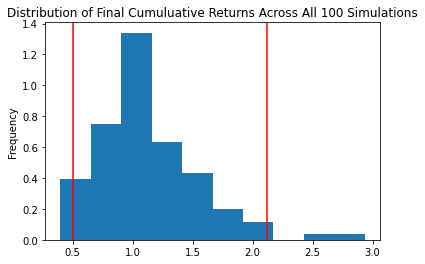

In [30]:
# Plot probability distribution and confidence intervals
dist_plot = mutant_ape_MC.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')

In [31]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = mutant_ape_MC.summarize_cumulative_return()

# Print summary statistics
#print(tbl)
calculate_lower_upper_bound_investment(collection_slug,initial_investment,tbl)
#investment_returns_all_collection_slug

There is a 95% chance that an initial investment of $10000 in the NFT collection mutant-ape-yacht-club over the next 30 days will end within in the range of $5002.64 and $21207.29


In [ ]:
#4

Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
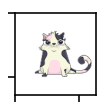
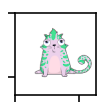
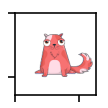
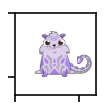
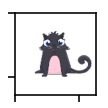
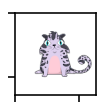
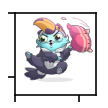
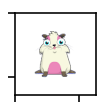
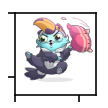
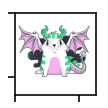

In [32]:
collection_slug="cryptokitties"
asset_limit=200
total_images_to_display=10

panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel



In [33]:
#get the stats for the collection for analysis
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats

file_name = determine_file_name(collection_slug,start_date,end_date)

dataframe_dict = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_cryptokitties_orig = dataframe_dict["dataframe_orig"] 
df_cryptokitties = dataframe_dict["dataframe_for_mc_sim"]
cryptokitties_line_chart= plot_hvplot_line(df_cryptokitties_orig,"event_date","close")
cryptokitties_line_chart

Fetching events between 2022-03-01 00:00:00 and 2022-08-22 00:00:00
fetching events for collection:cryptokitties,sleeping for:1, iteration: 1, limit:300
fetching events for collection:cryptokitties,sleeping for:1, iteration: 2, limit:300
total number of records found:438
writing data to file:Data/cryptokitties_03012022_08222022.csv


C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


:Curve   [event_date]   (close)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


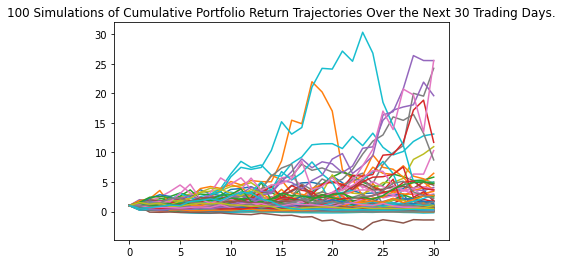

In [34]:
cryptokitties_MC = perform_monte_carlo_simulation(collection_slug,
                                                         df_cryptokitties,
                                                         num_of_simulation,
                                                         num_trading_days)

# Plot simulation outcomes
line_plot = cryptokitties_MC.plot_simulation()
sim_image_name=determine_simulation_image_name(collection_slug)
line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")

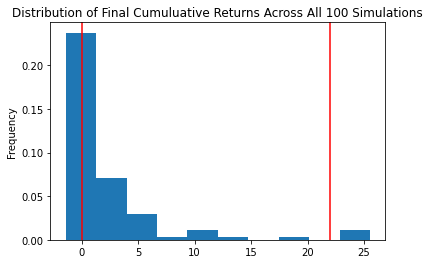

In [35]:
# Plot probability distribution and confidence intervals
dist_plot = cryptokitties_MC.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')

In [36]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = cryptokitties_MC.summarize_cumulative_return()

# Print summary statistics
#print(tbl)
calculate_lower_upper_bound_investment(collection_slug,initial_investment,tbl)
#investment_returns_all_collection_slug

There is a 95% chance that an initial investment of $10000 in the NFT collection cryptokitties over the next 30 days will end within in the range of $55.2 and $220250.35


In [ ]:
#5

Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
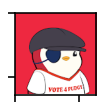
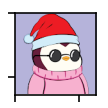
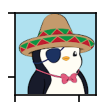
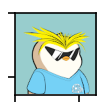
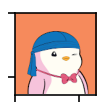
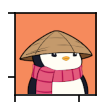
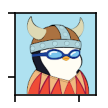
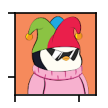
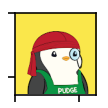
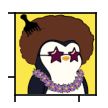

In [37]:
collection_slug="pudgypenguins"
panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel

In [38]:
#get the stats for the collection for analysis
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats

file_name = determine_file_name(collection_slug,start_date,end_date)
dataframe_dict = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_pudgypenguins_orig = dataframe_dict["dataframe_orig"] 
df_pudgypenguins = dataframe_dict["dataframe_for_mc_sim"]
pudgypenguins_line_chart= plot_hvplot_line(df_pudgypenguins_orig,"event_date","close")
pudgypenguins_line_chart

Fetching events between 2022-03-01 00:00:00 and 2022-08-22 00:00:00
fetching events for collection:pudgypenguins,sleeping for:1, iteration: 1, limit:300
fetching events for collection:pudgypenguins,sleeping for:1, iteration: 2, limit:300
fetching events for collection:pudgypenguins,sleeping for:1, iteration: 3, limit:300
fetching events for collection:pudgypenguins,sleeping for:1, iteration: 4, limit:300
fetching events for collection:pudgypenguins,sleeping for:1, iteration: 5, limit:300
fetching events for collection:pudgypenguins,sleeping for:1, iteration: 6, limit:300
fetching events for collection:pudgypenguins,sleeping for:1, iteration: 7, limit:300
fetching events for collection:pudgypenguins,sleeping for:1, iteration: 8, limit:300
fetching events for collection:pudgypenguins,sleeping for:1, iteration: 9, limit:300
fetching events for collection:pudgypenguins,sleeping for:1, iteration: 10, limit:300
fetching events for collection:pudgypenguins,sleeping for:1, iteration: 11, limit

C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


:Curve   [event_date]   (close)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


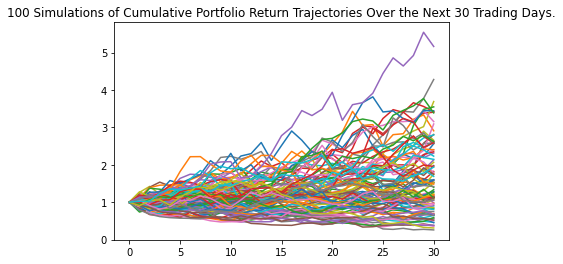

In [39]:
pudgypenguins_MC = perform_monte_carlo_simulation(collection_slug,
                                                         df_pudgypenguins,
                                                         num_of_simulation,
                                                         num_trading_days)

# Plot simulation outcomes
line_plot = pudgypenguins_MC.plot_simulation()
sim_image_name=determine_simulation_image_name(collection_slug)
line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")



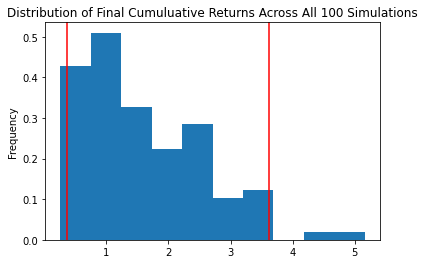

In [40]:
# Plot probability distribution and confidence intervals
dist_plot = pudgypenguins_MC.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')

In [41]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = pudgypenguins_MC.summarize_cumulative_return()

# Print summary statistics
#print(tbl)
calculate_lower_upper_bound_investment(collection_slug,initial_investment,tbl)
#investment_returns_all_collection_slug

There is a 95% chance that an initial investment of $10000 in the NFT collection pudgypenguins over the next 30 days will end within in the range of $3657.41 and $36216.91


In [ ]:
#6

Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
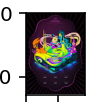
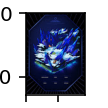
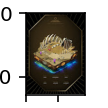
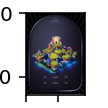
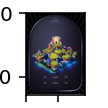
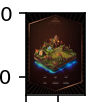
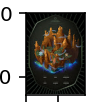
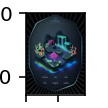
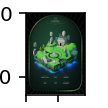
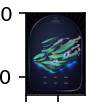

In [47]:
collection_slug="otherdeed"
panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel

In [48]:
#get the stats for the collection for analysis
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats

file_name = determine_file_name(collection_slug,start_date,end_date)
dataframe_dict = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_otherdeed_orig = dataframe_dict["dataframe_orig"] 
df_otherdeed = dataframe_dict["dataframe_for_mc_sim"]
otherdeed_line_chart= plot_hvplot_line(df_otherdeed_orig,"event_date","close")
otherdeed_line_chart

Fetching events between 2022-03-01 00:00:00 and 2022-08-22 00:00:00
fetching events for collection:otherdeed,sleeping for:1, iteration: 1, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 2, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 3, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 4, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 5, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 6, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 7, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 8, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 9, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 10, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 11, limit:300
fetching events for collection:otherdee

fetching events for collection:otherdeed,sleeping for:1, iteration: 101, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 102, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 103, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 104, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 105, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 106, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 107, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 108, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 109, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 110, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 111, limit:300
fetching events for collection:otherdeed,sleeping for:1, iteration: 112, limit:300
fetc

C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


:Curve   [event_date]   (close)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


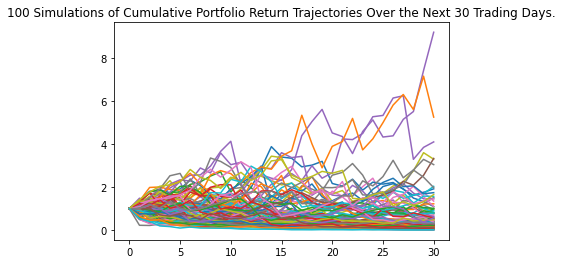

In [49]:
otherdeed_MC = perform_monte_carlo_simulation(collection_slug,
                                                         df_otherdeed,
                                                         num_of_simulation,
                                                         num_trading_days)

# Plot simulation outcomes
line_plot = otherdeed_MC.plot_simulation()
sim_image_name=determine_simulation_image_name(collection_slug)
line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")


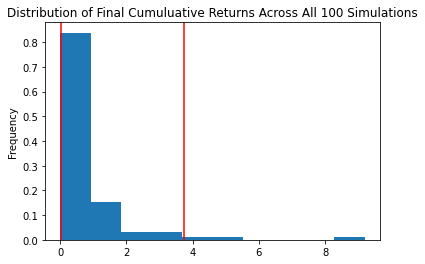

In [50]:
# Plot probability distribution and confidence intervals
dist_plot = otherdeed_MC.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')

In [51]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = otherdeed_MC.summarize_cumulative_return()

# Print summary statistics
#print(tbl)
calculate_lower_upper_bound_investment(collection_slug,initial_investment,tbl)
#investment_returns_all_collection_slug

There is a 95% chance that an initial investment of $10000 in the NFT collection otherdeed over the next 30 days will end within in the range of $175.93 and $37339.67


In [ ]:
#7

Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
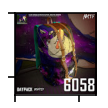
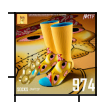
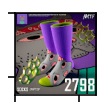
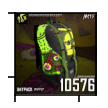
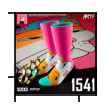
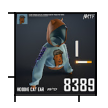
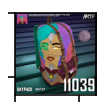
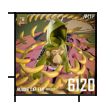
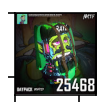
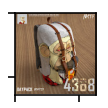

In [59]:
collection_slug="10ktf"
panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel

In [64]:
#get the stats for the collection for analysis
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats

file_name = determine_file_name(collection_slug,start_date,end_date)
dataframe_dict = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_10ktf_orig = dataframe_dict["dataframe_orig"] 
df_10ktf = dataframe_dict["dataframe_for_mc_sim"]
tenktf_line_chart= plot_hvplot_line(df_10ktf_orig,"event_date","close")
tenktf_line_chart

Fetching events between 2022-03-01 00:00:00 and 2022-08-22 00:00:00
fetching events for collection:10ktf,sleeping for:1, iteration: 1, limit:300
fetching events for collection:10ktf,sleeping for:1, iteration: 2, limit:300
fetching events for collection:10ktf,sleeping for:1, iteration: 3, limit:300
fetching events for collection:10ktf,sleeping for:1, iteration: 4, limit:300
fetching events for collection:10ktf,sleeping for:1, iteration: 5, limit:300
fetching events for collection:10ktf,sleeping for:1, iteration: 6, limit:300
fetching events for collection:10ktf,sleeping for:1, iteration: 7, limit:300
fetching events for collection:10ktf,sleeping for:1, iteration: 8, limit:300
fetching events for collection:10ktf,sleeping for:1, iteration: 9, limit:300
fetching events for collection:10ktf,sleeping for:1, iteration: 10, limit:300
fetching events for collection:10ktf,sleeping for:1, iteration: 11, limit:300
fetching events for collection:10ktf,sleeping for:1, iteration: 12, limit:300
fetch

C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


:Curve   [event_date]   (close)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


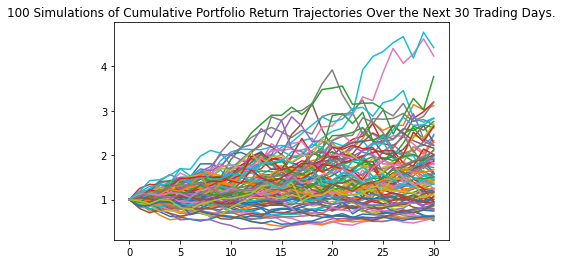

In [67]:
tenktf_MC = perform_monte_carlo_simulation(collection_slug,
                                                         df_10ktf,
                                                         num_of_simulation,
                                                         num_trading_days)

# Plot simulation outcomes
line_plot = tenktf_MC.plot_simulation()
sim_image_name=determine_simulation_image_name(collection_slug)
line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")


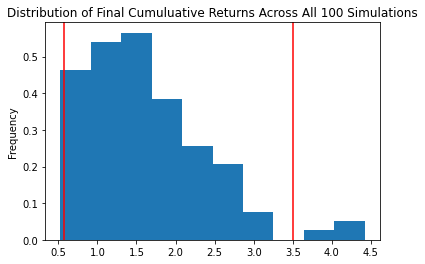

In [69]:
# Plot probability distribution and confidence intervals
dist_plot = tenktf_MC.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')

In [70]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = tenktf_MC.summarize_cumulative_return()

# Print summary statistics
#print(tbl)
calculate_lower_upper_bound_investment(collection_slug,initial_investment,tbl)
#investment_returns_all_collection_slug

There is a 95% chance that an initial investment of $10000 in the NFT collection 10ktf over the next 30 days will end within in the range of $5756.38 and $34973.89


In [ ]:
#8

Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
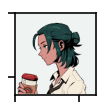
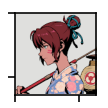
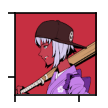
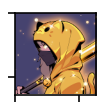
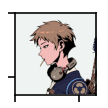
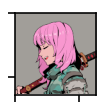
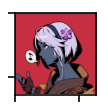
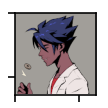
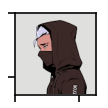
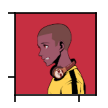

In [71]:
collection_slug="azuki"
panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel

In [72]:
#get the stats for the collection for analysis
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats

file_name = determine_file_name(collection_slug,start_date,end_date)
dataframe_dict = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_azuki_orig = dataframe_dict["dataframe_orig"] 
df_azuki = dataframe_dict["dataframe_for_mc_sim"]
azuki_line_chart= plot_hvplot_line(df_azuki_orig,"event_date","close")
azuki_line_chart

Fetching events between 2022-03-01 00:00:00 and 2022-08-22 00:00:00
fetching events for collection:azuki,sleeping for:1, iteration: 1, limit:300
fetching events for collection:azuki,sleeping for:1, iteration: 2, limit:300
fetching events for collection:azuki,sleeping for:1, iteration: 3, limit:300
fetching events for collection:azuki,sleeping for:1, iteration: 4, limit:300
fetching events for collection:azuki,sleeping for:1, iteration: 5, limit:300
fetching events for collection:azuki,sleeping for:1, iteration: 6, limit:300
fetching events for collection:azuki,sleeping for:1, iteration: 7, limit:300
fetching events for collection:azuki,sleeping for:1, iteration: 8, limit:300
fetching events for collection:azuki,sleeping for:1, iteration: 9, limit:300
fetching events for collection:azuki,sleeping for:1, iteration: 10, limit:300
fetching events for collection:azuki,sleeping for:1, iteration: 11, limit:300
fetching events for collection:azuki,sleeping for:1, iteration: 12, limit:300
fetch

C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


:Curve   [event_date]   (close)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


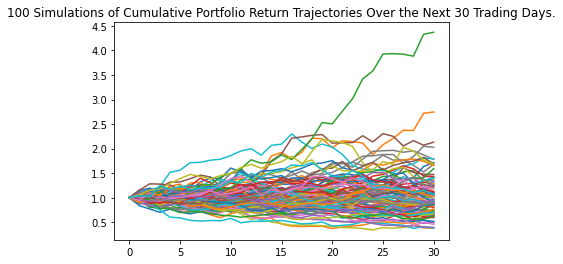

In [73]:
azuki_MC = perform_monte_carlo_simulation(collection_slug,
                                                         df_azuki,
                                                         num_of_simulation,
                                                         num_trading_days)

# Plot simulation outcomes
line_plot = azuki_MC.plot_simulation()
sim_image_name=determine_simulation_image_name(collection_slug)
line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")


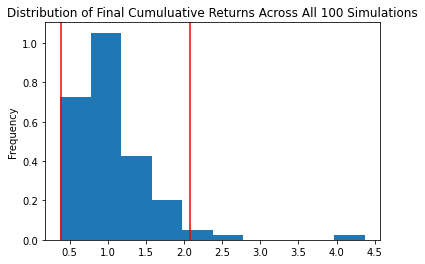

In [74]:
# Plot probability distribution and confidence intervals
dist_plot = azuki_MC.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')

In [75]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = azuki_MC.summarize_cumulative_return()

# Print summary statistics
#print(tbl)
calculate_lower_upper_bound_investment(collection_slug,initial_investment,tbl)
#investment_returns_all_collection_slug

There is a 95% chance that an initial investment of $10000 in the NFT collection azuki over the next 30 days will end within in the range of $3900.77 and $20819.65


In [ ]:
#9

Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
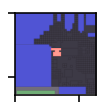
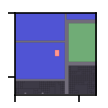
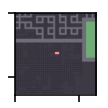
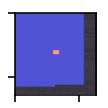
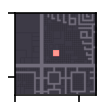
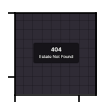
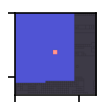
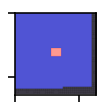
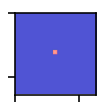
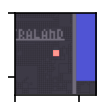

In [98]:
collection_slug="decentraland"
panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel

In [99]:
#get the stats for the collection for analysis
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats

file_name = determine_file_name(collection_slug,start_date,end_date)
dataframe_dict = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_decentraland_orig = dataframe_dict["dataframe_orig"] 
df_decentraland = dataframe_dict["dataframe_for_mc_sim"]
decentraland_line_chart= plot_hvplot_line(df_decentraland_orig,"event_date","close")
decentraland_line_chart

Fetching events between 2022-03-01 00:00:00 and 2022-08-22 00:00:00
fetching events for collection:decentraland,sleeping for:1, iteration: 1, limit:300
fetching events for collection:decentraland,sleeping for:1, iteration: 2, limit:300
fetching events for collection:decentraland,sleeping for:1, iteration: 3, limit:300
total number of records found:864
writing data to file:Data/decentraland_03012022_08222022.csv


C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


:Curve   [event_date]   (close)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


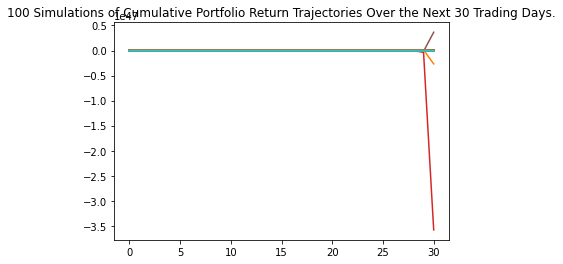

In [100]:
decentraland_MC = perform_monte_carlo_simulation(collection_slug,
                                                         df_decentraland,
                                                         num_of_simulation,
                                                         num_trading_days)

# Plot simulation outcomes
line_plot = decentraland_MC.plot_simulation()
sim_image_name=determine_simulation_image_name(collection_slug)
line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")

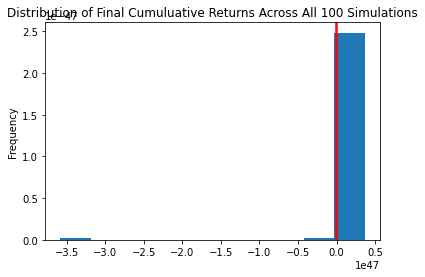

In [101]:
# Plot probability distribution and confidence intervals
dist_plot = decentraland_MC.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')

In [102]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = decentraland_MC.summarize_cumulative_return()

# Print summary statistics
#print(tbl)
calculate_lower_upper_bound_investment(collection_slug,initial_investment,tbl)
#investment_returns_all_collection_slug

There is a 95% chance that an initial investment of $10000 in the NFT collection decentraland over the next 30 days will end within in the range of $-4.830264100290608e+48 and $2.992691342428363e+48


In [ ]:
#10

Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
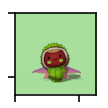
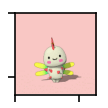
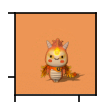
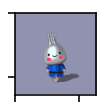
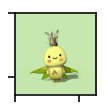
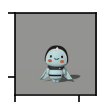
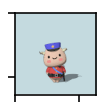
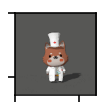
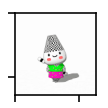
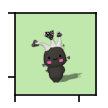

In [103]:
collection_slug="finiliar"
panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel

In [104]:
#get the stats for the collection for analysis
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats

file_name = determine_file_name(collection_slug,start_date,end_date)
dataframe_dict = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_finiliar_orig = dataframe_dict["dataframe_orig"] 
df_finiliar = dataframe_dict["dataframe_for_mc_sim"]
finiliar_line_chart= plot_hvplot_line(df_finiliar_orig,"event_date","close")
finiliar_line_chart

Fetching events between 2022-03-01 00:00:00 and 2022-08-22 00:00:00
fetching events for collection:finiliar,sleeping for:1, iteration: 1, limit:300
total number of records found:110
writing data to file:Data/finiliar_03012022_08222022.csv


C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\envs\NFTPriceTrackerAndForecaster-main\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


:Curve   [event_date]   (close)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


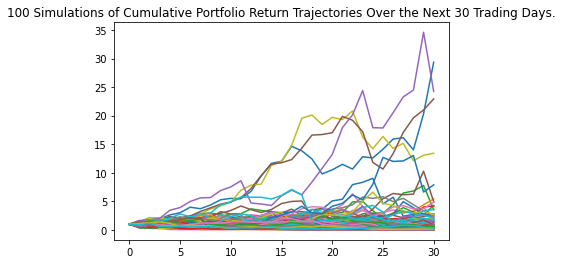

In [105]:
finiliar_MC = perform_monte_carlo_simulation(collection_slug,
                                                         df_finiliar,
                                                         num_of_simulation,
                                                         num_trading_days)

# Plot simulation outcomes
line_plot = finiliar_MC.plot_simulation()
sim_image_name=determine_simulation_image_name(collection_slug)
line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")

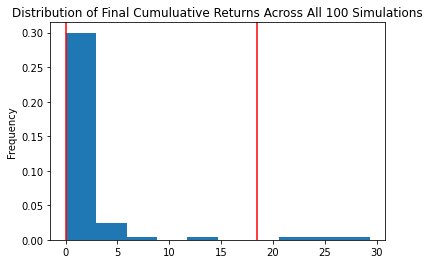

In [106]:
# Plot probability distribution and confidence intervals
dist_plot = finiliar_MC.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')

In [107]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = finiliar_MC.summarize_cumulative_return()

# Print summary statistics
#print(tbl)
calculate_lower_upper_bound_investment(collection_slug,initial_investment,tbl)
#investment_returns_all_collection_slug


There is a 95% chance that an initial investment of $10000 in the NFT collection finiliar over the next 30 days will end within in the range of $82.9 and $184078.88


In [108]:
#get Etherium current price using alpaca API
def get_etherium_price():
    eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"
    # Fetch current ETH price
    eth_response_data = requests.get(eth_url).json()
    #print(json.dumps(eth_response_data, indent=2))
    eth_price = eth_response_data["data"]["1027"]["quotes"]["CAD"]["price"]
    return eth_price

eth_price = get_etherium_price()
print(f"The current value of 1 ETH as of {datetime.datetime.now()} is ${eth_price:0.2f}")

The current value of 1 ETH as of 2022-08-23 23:53:29.086642 is $2125.41


In [109]:

#print(all_collection_stats)
def get_collection_stat_filtered_df(all_collection_stats):
    filtered_collection_stats = {}
    for key in all_collection_stats.keys():
        collection_data = all_collection_stats[key]
        total_sales = collection_data["stats"]["total_sales"]
        sales_30_days = collection_data["stats"]["thirty_day_sales"]
        average_price = collection_data["stats"]["average_price"]
        filter_values={}
        filter_values["total_sales"] =total_sales
        filter_values["sales_30_days"] =sales_30_days
        filter_values["average_price"] =average_price
        filtered_collection_stats[key]=filter_values
        #filtered_collection_stats[key]=collection_data["stats"]
        
    return filtered_collection_stats
    
filtered_collection_stats = get_collection_stat_filtered_df(all_collection_stats)
#filtered_collection_stats
collection_stats_df =pd.DataFrame(filtered_collection_stats)
collection_stats_df


,boredapeyachtclub,doodles-official,mutant-ape-yacht-club,cryptokitties,pudgypenguins,otherdeed,10ktf,azuki,cryptopunks,finiliar,moonbirds,decentraland
total_sales,26983.000000,23608.000000,34221.000000,785288.000000,37826.000000,44052.000000,20274.000000,27085.00000,21391.000000,6666.000000,0.0,20730.000000
sales_30_days,152.000000,335.000000,626.000000,681.000000,1188.000000,2834.000000,1009.000000,324.00000,203.000000,6183.000000,0.0,218.000000
average_price,24.228441,6.205627,12.999186,0.090296,1.598533,7.625847,0.559753,9.54055,46.159648,0.172415,0.0,7.858078


In [110]:
investment_returns_all_collections =pd.DataFrame(investment_returns_all_collection_slug)
investment_returns_all_collections

,boredapeyachtclub,doodles-official,mutant-ape-yacht-club,cryptokitties,pudgypenguins,otherdeed,10ktf,azuki,finiliar,decentraland
lower_bound,4897.02,5390.56,5002.64,55.20,3657.41,175.93,5756.38,3900.77,82.90,-4.830264e+48
upper_bound,21884.87,21384.84,21207.29,220250.35,36216.91,37339.67,34973.89,20819.65,184078.88,2.992691e+48


In [111]:
eth_amount_purchase = initial_investment/eth_price
print(f"Amount of ETH that can be purchased for initial investment of {initial_investment} is {eth_amount_purchase}")

Amount of ETH that can be purchased for initial investment of 10000 is 4.70496686602364


***Investment Analysis***

This notebook fetched the data for 5 popular NFT collections and fected the sales prices for past 6 months. It then used that data to run Monte Carlo (MC) simulations for next 30 days.
The result of MC simulations help predict with 95% accuracy the lower and upper bound of the investment in next 30 days.

Since, the NFTs are purchased in Etherium (ETH) , it gets the current price of ETH and determines the number of ETH that can be purchased for the initial investment amount. This helps to determine if there is enough ETH available to purchase a particular NFT collection based on the average price of the NFT collection asset.

The results of the simulation will vary with each run. The below screenshot shows the data for a particular run

![Investment_Analysis.png](Images/Investment_Analysis.png)

Based on the results in image above, we can determine that the amount of ETH available for NFT purchase is `2.63` for investment of `10,000` CAD. Based on the average price of the NFT assets, the only 2 assets that can be purchased are cryptokitties (`0.090138 ETH`)  and pudgypenguins (`1.515286`)

Although the upper bound for cryptokitties is higher than pudgypenguins, it can also result in total loss of investment. So based on the risk appetite of the investor , this notebook can compare such data for different NFT assets and help the investor to determine which NFT asset to invest in.

If the investor is willing to invest higer amounts in NFT, then doodles-official might be a safer option given the lower bound of `7028.84` and upper bound of `20074.96`

The other statistical data like total number of sales and number of sales in past 30 days, will help determine the overall activity for the NFT collection and thus liquidity in the NFT marketplace to make informed decision for those interested in trading.